<a href="https://colab.research.google.com/github/jashvidesai/ORF-Thesis/blob/main/VRPTW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 86.4 MB/s eta 0:00:00


In [3]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

# Example parameters
V = range(4)  # nodes including depot, 0 is depot
V_star = range(1, 4)  # nodes excluding depot
K = range(5)  # two vehicles for example
Q = 15  # capacity of each vehicle
M = 10000  # large constant for constraints
M_2 = 10000 # another large constraint for constraints
vehicle_speed = 60  # vehicle speed in km/h

# DISTANCES
np.random.seed(42)
distances = np.random.randint(10, 51, size=(len(V), len(V)))
# distance matrix symmetric and set the diagonal to 0
for i in V:
    distances[i, i] = 0
    for j in range(i + 1, len(V)):
        distances[j, i] = distances[i, j]

# triangle inequality enforced
for i in V:
    for j in V:
        for k in V:
            if distances[i, j] > distances[i, k] + distances[k, j]:
                distances[i, j] = distances[i, k] + distances[k, j]

# calculate travel times (distance / speed) and travel costs (distance * $0.15/mile * 0.62 mile/km)
# $0.15/mile is the average American cost for gas as per New York Times
t = distances / vehicle_speed
c = distances * 0.093

# Sample demands (including depot which has 0 demand)
d = [0, 5, 10, 8]

# time window parameters
a = [0, 10, 15, 20]
b = [100, 100, 100, 100]
s = [30, 30, 30, 30]

# Model setup
model = gp.Model("VRPTW")

# Decision variables
x = model.addVars(V, V, vtype=GRB.BINARY, name="x")  # binary variable
q = model.addVars(V, vtype=GRB.CONTINUOUS, name="q")  # continuous variable
tau = model.addVars(V, vtype=GRB.CONTINUOUS, name="tau") # continuous variable

# objective fn.
model.setObjective(gp.quicksum(c[i, j] * x[i, j] for i in V for j in V), GRB.MINIMIZE)

# constraints

# constraint 1, 2
for j in V_star:
    model.addConstr(gp.quicksum(x[i, j] for i in V) == 1, name=f"visit_{j}")
for i in V_star:
    model.addConstr(gp.quicksum(x[i, j] for j in V) == 1, name=f"departure_{i}")

# constraint 3, 4
model.addConstr(gp.quicksum(x[i, 0] for i in V_star) <= len(K), name="vehicle_out")
model.addConstr(gp.quicksum(x[0, j] for j in V_star) <= len(K), name="vehicle_in")

# constraint 5 (fleet size)
model.addConstr(gp.quicksum(x[0, j] for j in V_star) <= np.ceil(sum(d[i] for i in V_star) / Q), name="fleet_capacity")

# constraint 6 (set depot demand 0)
model.addConstr(q[0] == 0, name="depot_demand")

# constraint 7, 8, 9 (subtour elimination)
model.addConstrs((q[i] + d[j] <= q[j] + Q * (1 - x[i, j]) for i in V_star for j in V_star), name="load_balance1")
model.addConstrs((q[i] + d[j] >= q[j] - M * (1 - x[i, j]) for i in V_star for j in V_star), name="load_balance2")
model.addConstrs((q[i] >= d[i] for i in V_star), name="demand_lower_bound")
model.addConstrs((q[i] <= Q for i in V_star), name="demand_upper_bound")

# constraint 10 (service time subtour)
model.addConstrs((tau[i] + s[i] + t[i, j] <= tau[j] + M_2 * (1 - x[i, j]) for i in V_star for j in V_star if i != j), name="service_time")

# constraint 11 (tau bounds)
model.addConstrs((a[i] <= tau[i] for i in V_star), name="time_window_start")
model.addConstrs((tau[i] <= b[i] for i in V_star), name="time_window_end")

# set depot time to zero
model.addConstr(tau[0] == 0, name="depot_time")

# solve
model.optimize()

# output
if model.status == GRB.OPTIMAL:
    solution = model.getAttr('x', x)
    for i in V:
        for j in V:
            if solution[i, j] > 0.5:
                print(f"Edge ({i}, {j}) is in the optimal route with cost {c[i, j]}")
    satisfied_demand = model.getAttr('x', q)
    for i in V:
        print(f"Demand satisfied at node {i}: {satisfied_demand[i]}")
else:
    print("No optimal solution found.")

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 47 rows, 24 columns and 107 nonzeros
Model fingerprint: 0xae80c409
Variable types: 8 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 12.5550000
Presolve removed 36 rows and 15 columns
Presolve time: 0.00s
Presolved: 11 rows, 9 columns, 44 nonzeros
Variable types: 5 continuous, 4 integer (4 binary)

Root relaxation: objective 1.153200e+01, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth Int

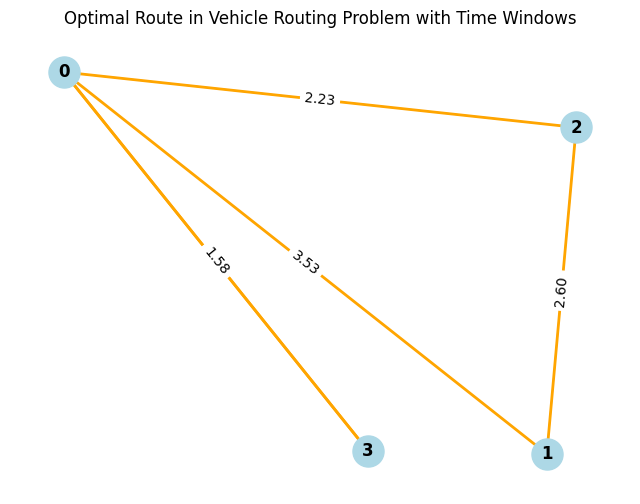

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a graph for visualization using NetworkX
G = nx.Graph()

# Add nodes to the graph
for node in V:
    G.add_node(node, pos=(np.random.rand() * 100, np.random.rand() * 100))  # random positions

# Add edges and labels for optimal paths in the solution
edges_in_route = []
if model.status == GRB.OPTIMAL:
    solution = model.getAttr('x', x)
    for i in V:
        for j in V:
            if solution[i, j] > 0.5:  # If edge (i, j) is in the optimal route
                G.add_edge(i, j, weight=c[i, j])
                edges_in_route.append((i, j))

# Get positions of nodes for plotting
pos = nx.get_node_attributes(G, 'pos')

# Draw nodes
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Draw all edges
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Highlight edges in the optimal route
nx.draw_networkx_edges(G, pos, edgelist=edges_in_route, width=2, edge_color='orange')

# Add edge labels with travel costs for edges in the route
edge_labels = {(i, j): f"{c[i, j]:.2f}" for (i, j) in edges_in_route}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Optimal Route in Vehicle Routing Problem with Time Windows")
plt.axis("off")
plt.show()